In [1]:
from datascience import *
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

# Lecture 04

## Percentiles 

Suppose we wanted to manually compute the 55th percentile of the following array:

In [2]:
x = make_array(43, 20, 51, 7, 28)

**Step 1.** To compute percentiles we first sort the data

In [3]:
sorted_x = np.sort(x) # EXERCISE
sorted_x

array([ 7, 20, 28, 43, 51])

In [4]:
ptbl = Table().with_columns(
    "Percentile", 100*(np.arange(0, len(x))+1)/len(x),
    "Element", sorted_x)
ptbl

Percentile,Element
20,7
40,20
60,28
80,43
100,51


**Step 2.** Figure out where the $p^\text{th}$ percentile would be.

In [5]:
p = 55
ind = 55/100 * 5 # EXERCISE
ind # know it is the 3rd element, 28

#ind = int(np.ceil(len(x) * p/100) - 1)
#ind

2.75

In [6]:
sorted_x.item(ind)

TypeError: 'float' object cannot be interpreted as an integer

In [7]:
p = 0
ind = p/100 * 5
ind
sorted_x.item(int(ind))

7

The above calculation is confusing and brittle (try p=0).  Instead, we should use the `percentile` function.

### Using the Percentile Function

In [8]:
percentile?

Signature: percentile(p, arr=None)
Docstring:
Returns the pth percentile of the input array (the value that is at
least as great as p% of the values in the array).

If arr is not provided, percentile returns itself curried with p

>>> percentile(74.9, [1, 3, 5, 9])
5
>>> percentile(75, [1, 3, 5, 9])
5
>>> percentile(75.1, [1, 3, 5, 9])
9
>>> f = percentile(75)
>>> f([1, 3, 5, 9])
5
File:      /opt/conda/lib/python3.11/site-packages/datascience/util.py
Type:      function

Recall the precentile table. 

In [9]:
ptbl

Percentile,Element
20,7
40,20
60,28
80,43
100,51


Let's try a few values.

In [10]:
percentile(50, x)

28

In [11]:
percentile(55, x)
percentile(60,x)
percentile(61,x)

43

In [12]:
percentile(0, x)

7

In [13]:
percentile(100, x)

51

---
<center> Return to Slides </center>

---

## Discussion Question

In [14]:
s = make_array(1, 7, 3, 9, 5)
s

array([1, 7, 3, 9, 5])

In [15]:
Table().with_columns(
    "Percentile", 100*(np.arange(0, len(s))+1)/len(s),
    "Element", sorted(s))

Percentile,Element
20,1
40,3
60,5
80,7
100,9


In [16]:
percentile(10, s) == 0 # should be element 1

False

In [17]:
percentile(39, s) == percentile(40, s) # element 3

True

In [18]:
percentile(40, s) == percentile(41, s) # element 3 does not equal to element 5

False

In [19]:
percentile(50, s) == 5

True

---
<center> Return to Slides </center>

---

## Inference: Estimation

To demonstrate the process of estimating a parameter, let's examine the 2019 San Francisco public records.  We obtained this data from the [SF Open Data Portal](https://datasf.org/opendata/).  For the purposes of this exercise, we will assume that this a census of the compensation data: that it contains the compensation for a public workers.  

In [20]:
sf = Table().read_table('data/san_francisco_2019.csv')
sf.show(3)

Organization Group,Department,Job Family,Job,Salary,Overtime,Benefits,Total Compensation
Public Protection,Adult Probation,Information Systems,IS Trainer-Journey,91332,0,40059,131391
Public Protection,Adult Probation,Information Systems,IS Engineer-Assistant,123241,0,49279,172520
Public Protection,Adult Probation,Information Systems,IS Business Analyst-Senior,115715,0,46752,162468


Suppose we are interested in studying `"Total Compensation"`.  Let's make a histogram of the total compensation.

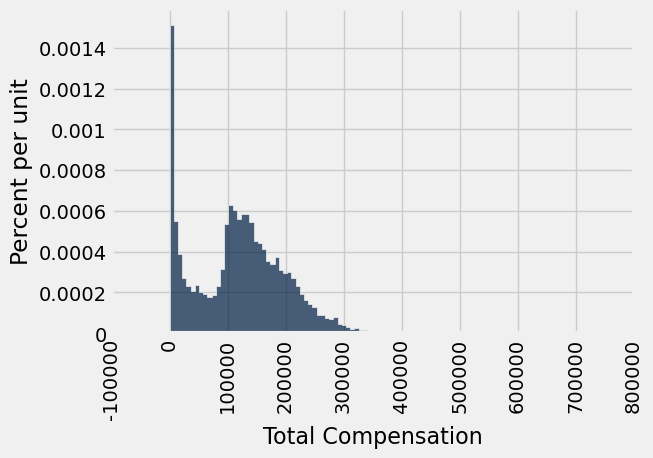

In [21]:
sf.hist('Total Compensation', bins = 100)

Who is getting paid the most?

In [22]:
sf.sort('Total Compensation', descending = True). show(5)

Organization Group,Department,Job Family,Job,Salary,Overtime,Benefits,Total Compensation
General Administration & Finance,Retirement Services,Administrative & Mgmt (Unrep),Chief Investment Officer,577633,0,146398,724031
General Administration & Finance,Retirement Services,Unassigned,Managing Director,483072,0,134879,617951
General Administration & Finance,Retirement Services,Unassigned,Managing Director,482649,0,134905,617554
General Administration & Finance,Retirement Services,Unassigned,Managing Director,451507,0,120276,571784
General Administration & Finance,Retirement Services,Unassigned,Managing Director,449378,0,120857,570235


Who is getting paid the least?

In [23]:
sf.sort('Total Compensation').show(10) # default behavior of sort Table operation is to show descending = False
# smallest to greatest

Organization Group,Department,Job Family,Job,Salary,Overtime,Benefits,Total Compensation
Public Protection,Adult Probation,Probation & Parole,Deputy Probation Officer,0,0,0,0
Public Protection,Fire Department,"Clerical, Secretarial & Steno",Senior Clerk Typist,0,0,0,0
Public Protection,Juvenile Court,Correction & Detention,"Counselor, Juvenile Hall PERS",0,0,0,0
Public Protection,Police,"Clerical, Secretarial & Steno",Clerk Typist,0,0,0,0
Public Protection,Sheriff,Correction & Detention,Deputy Sheriff,0,0,0,0
"Public Works, Transportation & Commerce",Airport Commission,Sub-Professional Engineering,StdntDsgn Train2/Arch/Eng/Plng,0,0,0,0
"Public Works, Transportation & Commerce",Airport Commission,"Clerical, Secretarial & Steno",Executive Secretary 1,0,0,0,0
"Public Works, Transportation & Commerce",Airport Commission,"Payroll, Billing & Accounting",Senior Account Clerk,0,0,0,0
"Public Works, Transportation & Commerce",Airport Commission,Housekeeping & Laundry,Custodian,0,0,0,0
"Public Works, Transportation & Commerce",Airport Commission,Housekeeping & Laundry,Custodian,0,0,0,0


There is a clear spike around **zero**!  Why?

We will focus on those that worked at least 20 hours at minimum wage for an entire year. 

In [24]:
min_salary = 15 * 20 * 50 # $15/hr, 20 hr/wk, 50 weeks
print("Min Salary", min_salary)

sf = sf.where('Salary', are.above(min_salary)) # EXERCISE filter total compensation above min_salary

Min Salary 15000


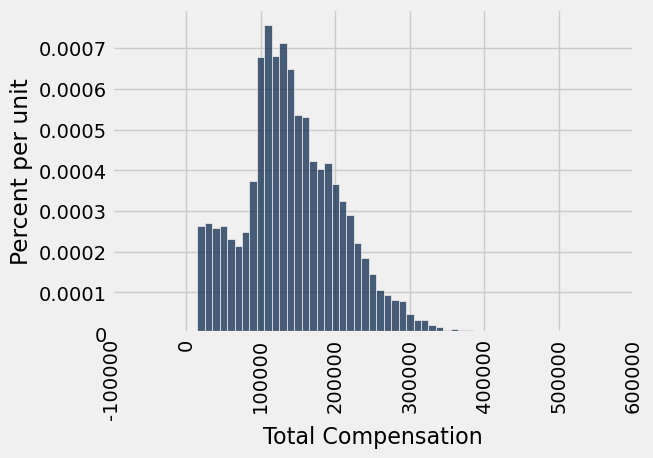

In [25]:
salary_bins = np.arange(min_salary, 500000, 10000)
sf.hist("Total Compensation", bins=salary_bins)

### The Population Parameter

Here we have access to the population so we can compute parameters directly.  

For example, suppose we were interested in the median compensation.  Then we could compute it directly on our data:

In [26]:
pop_median = percentile(50, sf.column("Total Compensation"))
pop_median

135747.0

In most real-world settings, you won't have access to the population.  Instead, you will take a random sample. 

Suppose we sample 400 people from our population.

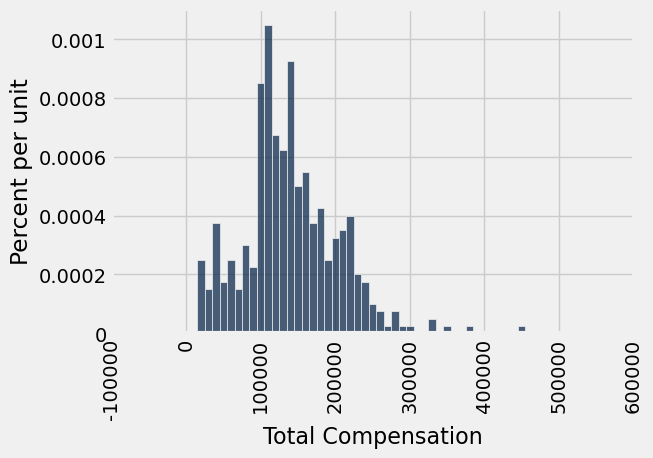

In [27]:
# An Empirical Distribution
our_sample = sf.sample(400, with_replacement = False) # EXERCISE: sample 400 from population
our_sample.hist('Total Compensation', bins=salary_bins)

We can use the sample median (statistic) as an estimate of the parameter value.

In [28]:
# Estimate: Median of a Sample
percentile(50, our_sample.column('Total Compensation'))

134410.0

But in the real world we won't be able to keep going back to the population. How do we generate a new random sample *without going back to the population?*

---
<center> Return to Slides </center>

---

## Variability of the Estimate

If we could get additional samples from the population, how much variability would their be in our estimate of the median?

In [29]:
def generate_sample_median(samp_size):
    new_sample = sf.sample(samp_size, with_replacement = False) # EXERCISE: sample 400 from population
    new_percentile = percentile(50, new_sample.column('Total Compensation'))
    return new_percentile

In [30]:
generate_sample_median(400)

133796.0

## Quantifying Uncertainty

Because we have access to the population, we can simulate many samples from the population:

In [31]:
sample_medians = make_array() # initialize an array
# so we can put stuff in here later, in our for loop
# record each of the sample medians we generate using generate_sample_median(samp_size)

for i in np.arange(1000): # generate 1,000 sample medians
    # Exercise
    new_median = generate_sample_median(400)
    sample_medians = np.append(sample_medians, new_median)

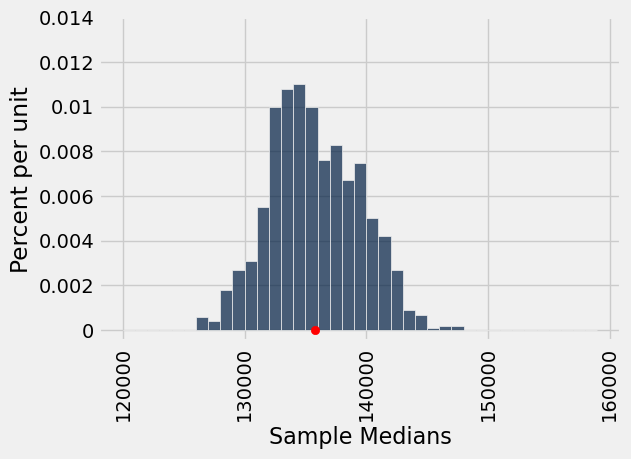

In [32]:
med_bins = np.arange(120000, 160000, 1000)
Table().with_column('Sample Medians', sample_medians).hist(bins=med_bins)

plots.ylim(-0.000005, 0.00014)
plots.scatter(pop_median, 0, color='red');

# great! we were able to simulate the population median compensation (true parameter) a ton of times
# with a sample size of 400
# with a random sample size of 400, we are able to represent the true parameter or true median compensation pretty well!


What happens if we do the same thing again with slightly larger samples?

In [33]:
sample_medians2 = make_array()

for i in np.arange(1000):
    new_median = generate_sample_median(800)
    sample_medians2 = np.append(sample_medians2, new_median)

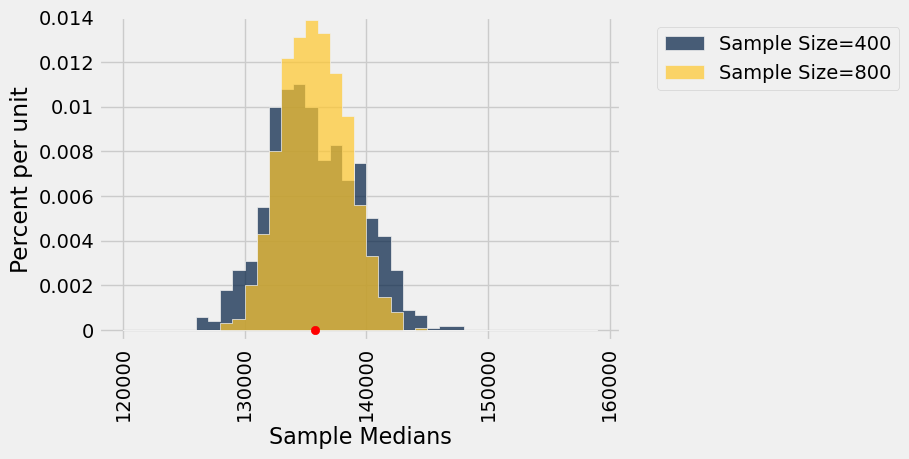

In [34]:
(Table()
     .with_columns("Sample Medians", sample_medians,
                   "Sample Size", 400)
     .append(Table().with_columns("Sample Medians", sample_medians2,
                                  "Sample Size", 800))
     .hist("Sample Medians", group="Sample Size", bins=med_bins)
)
plots.ylim(-0.000005, 0.00014)
plots.scatter(pop_median, 0, color='red');

# make sense of the graph below
# what does this mean?
# how does sample size affect our estimates?

# they're both good at estimating the true parameter, they're both centered at the true parameter
# one is better at approximating the true parameter more, in other words, there is less variability in the median compensation
# our yellow graph is narrower, which means there is less variability in our estimates
# estimates are closer and better approximations of our true parameter


But in the real world we won't be able to keep going back to the population. How do we generate a new random sample *without going back to the population?*

---
<center> Return to Slides </center>

---

# Bootstrap

Sample randomly
 - from the original sample
 - with replacement
 - the same number of times as the original sample size

**Step 1:** Sample the original sample **With Replacement** the same number of times as the original sample size.

```python
table.sample() # All you need!
```

The default behavior of tbl.sample:
1. at random with replacement,
2. the same number of times as rows of tbl

In [35]:
Table.sample?


Signature: Table.sample(self, k=None, with_replacement=True, weights=None)
Docstring:
Return a new table where k rows are randomly sampled from the
original table.

Args:
    ``k`` -- specifies the number of rows (``int``) to be sampled from
       the table. Default is k equal to number of rows in the table.

    ``with_replacement`` -- (``bool``) By default True;
        Samples ``k`` rows with replacement from table, else samples
        ``k`` rows without replacement.

    ``weights`` -- Array specifying probability the ith row of the
        table is sampled. Defaults to None, which samples each row
        with equal probability. ``weights`` must be a valid probability
        distribution -- i.e. an array the length of the number of rows,
        summing to 1.

Raises:
    ValueError -- if ``weights`` is not length equal to number of rows
        in the table; or, if ``weights`` does not sum to 1.

Returns:
    A new instance of ``Table`` with ``k`` rows resampled.

>>> jobs = T

In [36]:
our_sample # original sample of 400

Organization Group,Department,Job Family,Job,Salary,Overtime,Benefits,Total Compensation
General Administration & Finance,Administrative Services,Pub Relations & Spec Assts,Customer Service Agent Trainee,31148,12,8339,39499
"Public Works, Transportation & Commerce",Municipal Transportation Agcy,Street Transit,Transit Operator,62042,14193,36702,112938
"Public Works, Transportation & Commerce",Municipal Transportation Agcy,"Payroll, Billing & Accounting",Accountant III,93798,0,40612,134410
"Public Works, Transportation & Commerce",Municipal Transportation Agcy,Information Systems,IT Operations Support Admin IV,127773,0,42941,170713
"Public Works, Transportation & Commerce",Department Of Public Works,Professional Engineering,Assistant Engineer,115032,0,47329,162361
General Administration & Finance,Administrative Services,Public Service Aide,Public Service Trainee,33642,0,24833,58475
"Public Works, Transportation & Commerce",Airport Commission,Information Systems,IT Operations Support Admn III,116666,0,44419,161085
"Public Works, Transportation & Commerce",Public Utilities Commission,Professional Engineering,Engineer,161101,0,57747,218848
Public Protection,Police,Police Services,Police Officer,19732,315,8351,28397
"Public Works, Transportation & Commerce",Airport Commission,Housekeeping & Laundry,Custodian,70668,2022,34397,107087


In [42]:
bootstrap_sample = our_sample.sample() # EXERCISE
print("Number of Rows:", bootstrap_sample.num_rows)
bootstrap_sample

Number of Rows: 400


Organization Group,Department,Job Family,Job,Salary,Overtime,Benefits,Total Compensation
"Public Works, Transportation & Commerce",Municipal Transportation Agcy,Street Transit,Transit Operator,85439,27075,41746,154261
Public Protection,Fire Department,Fire Services,"Captain, Fire Suppression",188874,2542,53766,245182
Culture & Recreation,Recreation And Park Commission,Agriculture & Horticulture,Gardener,68351,2626,33181,104158
Community Health,Public Health,Nursing,Registered Nurse,195209,16991,68677,280878
"Public Works, Transportation & Commerce",Department Of Public Works,Information Systems,IS Engineer-Principal,175742,0,60786,236529
Human Welfare & Neighborhood Development,Human Services,Personnel,Training Officer,78485,0,33390,111875
"Public Works, Transportation & Commerce",Public Utilities Commission,Administrative-DPW/PUC,Water Operations Analyst,130646,4645,50402,185692
Culture & Recreation,Recreation And Park Commission,Housekeeping & Laundry,Custodial Supervisor,79809,9067,37976,126852
Human Welfare & Neighborhood Development,Human Services,Human Services,HSA Sr Eligibility Worker,89638,40,40235,129913
Community Health,Public Health,"Payroll, Billing & Accounting",Accountant Intern,16296,0,8124,24420


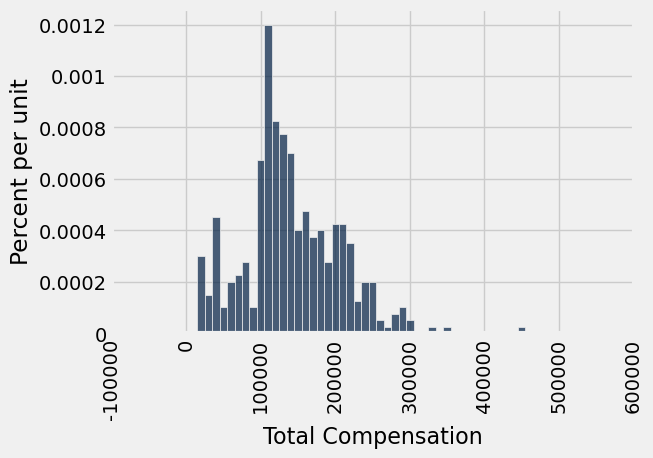

In [43]:
bootstrap_sample.hist('Total Compensation', bins=salary_bins)

**Step 2:** Compute statistic on bootstrap sample.

In [44]:
percentile(50, bootstrap_sample.column('Total Compensation'))

131051.0

**Repeat** the sampling process many times:

In [40]:
def one_bootstrap_median():
    # draw the bootstrap sample
    bootstrap_sample = our_sample.sample()  # Exercise
    # return the median total compensation in the bootstrap sample
    return percentile(50, bootstrap_sample.column('Total Compensation'))

In [41]:
one_bootstrap_median()

137762.0

In [45]:
# Generate the medians of 1000 bootstrap samples
num_repetitions = 1000
bstrap_medians = make_array()
for i in np.arange(num_repetitions):
    bstrap_medians = np.append(bstrap_medians, one_bootstrap_median())

Examine the empirical distribution of the samples.

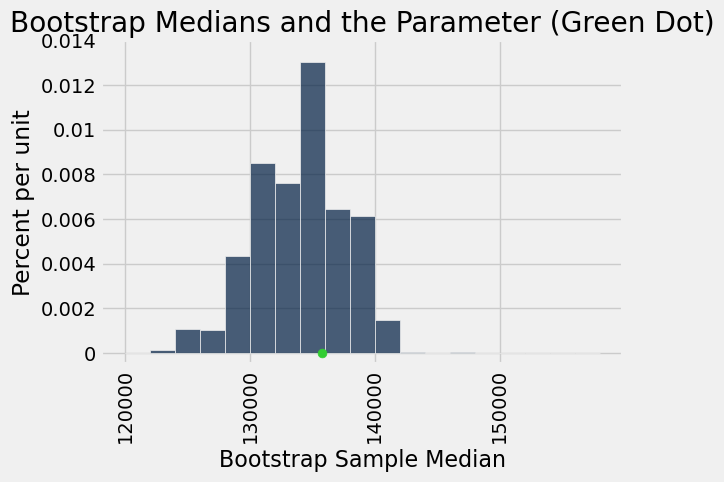

In [46]:
resampled_medians = Table().with_column('Bootstrap Sample Median', bstrap_medians)
median_bins=np.arange(120000, 160000, 2000)
resampled_medians.hist(bins = median_bins)

# Plotting parameters; you can ignore this code
parameter_green = '#32CD32'
plots.ylim(-0.000005, 0.00014)
plots.scatter(pop_median, 0, color=parameter_green, s=40, zorder=2)
plots.title('Bootstrap Medians and the Parameter (Green Dot)');

### A General Bootstrap Function

The following function implements the general bootstrap procedure.


In [ ]:
def bootstrapper(sample, statistic, num_repetitions):
    """
    Returns the statistic computed on a num_repetitions  
    bootstrap samples from sample.
    """
    bstrap_stats = make_array()
    for i in np.arange(num_repetitions):
        # Step 1: Sample the Sample
        bootstrap_sample = ... # EXERCISE
        # Step 2: compute statistics on the sample of the sample
        bootstrap_stat = ... # EXERCISE
        # Accumulate the statistics
        bstrap_stats = np.append(bstrap_stats, bootstrap_stat)

    return bstrap_stats    

In [ ]:
og_sample = sf.sample(400)

def compute_median(sample):
    return percentile(50, sample.column("Total Compensation"))

bootstrap_medians = bootstrapper(og_sample, compute_median, 1000)

In [ ]:
(Table().with_column("bootstraps", bootstrap_medians)
        .hist(bins=median_bins))

## Extra Viz code
parameter_green = '#32CD32'
plots.ylim(-0.000005, 0.00014)
plots.scatter(pop_median, 0, color=parameter_green, s=40, zorder=2)
plots.title('Bootstrap Medians and the Parameter (Green Dot)');

---
<center> Return to Slides </center>

---

## Percentile Method: Middle 95% of the Bootstrap Estimates 

Computing confidence intervals is as simple as computing percentiles on the bootstrap samples.  No magic equations!

In [ ]:
left = ... # EXERCISE 2.5 percentile
right = ... # EXERCISE 97.5 percentile 

make_array(left, right)

In [ ]:
resampled_medians.hist(bins = median_bins)

# Plotting parameters; you can ignore this code
plots.ylim(-0.000005, 0.00014)
plots.plot(make_array(left, right), make_array(0, 0), color='yellow', lw=3, zorder=1)
plots.scatter(pop_median, 0, color=parameter_green, s=40, zorder=2);